In [1]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [2]:
import numpy as np
# from aniposelib.boards import CharucoBoard, Checkerboard
from aniposelib.cameras import Camera, CameraGroup
from aniposelib.utils import load_pose2d_fnames

In [5]:

""" 
IMPORTS
"""
import os
import numpy as np
import pickle
import pandas as pd
from one.api import ONE
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from scipy import stats
from brainbox.io.one import SessionLoader
import scipy.interpolate as interpolate


# Get my functions
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
functions_path =  prefix + 'representation_learning_variability/Functions/'
os.chdir(functions_path)
from data_processing import save_and_log

one = ONE(mode='remote')

In [6]:
# LOAD DATA
bin_size = 0.017

num_train_batches = 5

data_path =prefix + 'representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v6_21Jul2025/' + str(bin_size) + '/'
all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices, bin_size)

# Subsample and embedd 

In [11]:
# Identify sessions availableto process
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    sessions_to_process.append((mouse_name, session))

In [12]:
def resample_common_time(reference_time, timestamps, data, kind, fill_gaps=None):
    
    # # t = np.arange(t_init, t_end, 1 / freq)  # Evenly resample at frequency
    # if reference_time[-1] > timestamps[-1]:
    #     reference_time = reference_time[:-1]  # Occasionally due to precision errors the last sample may be outside of range.
    yinterp = interpolate.interp1d(timestamps, data, kind=kind, fill_value='extrapolate')(reference_time)
    
    if fill_gaps:
        #  Find large gaps and forward fill @fixme This is inefficient
        gaps, = np.where(np.diff(timestamps) >= fill_gaps)

        for i in gaps:
            yinterp[(reference_time >= timestamps[i]) & (reference_time < timestamps[i + 1])] = data[i]
            
    return yinterp, reference_time

In [13]:
session = sessions_to_process[7][1]

""" LOAD VARIABLES """
sl = SessionLoader(eid=session, one=one)
sl.load_pose(views=['left', 'right'], tracker='lightningPose')
sl.load_session_data(trials=True, wheel=True, motion_energy=True)

poses = sl.pose

# Camera times
leftCam_time = np.array(poses['leftCamera']['times'])
rightCam_time = np.array(poses['rightCamera']['times'])

# Left paw Left camera
l_paw_x_leftCam = np.array(poses['leftCamera']['paw_l_x'])
l_paw_y_leftCam = np.array(poses['leftCamera']['paw_l_y'])
# Left paw Right camera
l_paw_x_rightCam = np.array(poses['rightCamera']['paw_r_x'])
l_paw_y_rightCam = np.array(poses['rightCamera']['paw_r_y'])

""" COMMON TIMESTAMPS AND RESAMPLING"""
# Use reference time, truncate and resample
onset = np.max([np.min(leftCam_time), np.min(rightCam_time)])
offset = np.min([np.max(leftCam_time), np.max(rightCam_time)])

common_fs = 60
# Set common sampling rate (high rather than low)
reference_time = np.arange(onset, offset, 1/common_fs)  # uniform timestamps

l_paw_x_leftCam = l_paw_x_leftCam[np.where((leftCam_time >= onset) & (leftCam_time < offset))]
l_paw_y_leftCam = l_paw_y_leftCam[np.where((leftCam_time >= onset) & (leftCam_time < offset))]
l_paw_x_rightCam = l_paw_x_rightCam[np.where((rightCam_time >= onset) & (rightCam_time < offset))]
l_paw_y_rightCam = l_paw_y_rightCam[np.where((rightCam_time >= onset) & (rightCam_time < offset))]

rightCam_time = rightCam_time[np.where((rightCam_time >= onset) & (rightCam_time < offset))]
leftCam_time = leftCam_time[np.where((leftCam_time >= onset) & (leftCam_time < offset))]

donwsampled_l_paw_x_leftCam, corrected_l_paw_x_leftCam_t = resample_common_time(reference_time, leftCam_time, l_paw_x_leftCam, kind='linear', fill_gaps=None)
donwsampled_l_paw_y_leftCam, corrected_l_paw_y_leftCam_t = resample_common_time(reference_time, leftCam_time, l_paw_y_leftCam, kind='linear', fill_gaps=None)

donwsampled_l_paw_x_rightCam, corrected_l_paw_x_rightCam_t = resample_common_time(reference_time, rightCam_time, l_paw_x_rightCam, kind='linear', fill_gaps=None)
donwsampled_l_paw_y_rightCam, corrected_l_paw_y_rightCam_t = resample_common_time(reference_time, rightCam_time, l_paw_y_rightCam, kind='linear', fill_gaps=None)

# Check integrity of data
# assert (corrected_l_paw_x_t == corrected_r_paw_x_t).all(), print('Assertion error')

TypeError: SessionLoader.load_pose() got an unexpected keyword argument 'tracker'

In [14]:
p2ds = np.zeros((2, len(donwsampled_l_paw_x_rightCam), 2)) * np.nan
p2ds[0, :, 0] = donwsampled_l_paw_x_rightCam
p2ds[0, :, 1] = donwsampled_l_paw_y_rightCam
p2ds[1, :, 0] = donwsampled_l_paw_x_leftCam
p2ds[1, :, 1] = donwsampled_l_paw_y_leftCam


NameError: name 'donwsampled_l_paw_x_rightCam' is not defined

In [136]:
np.save('p2ds', p2ds)

# Loading saved data

In [7]:
p2ds = np.load(functions_path +'p2ds.npy')

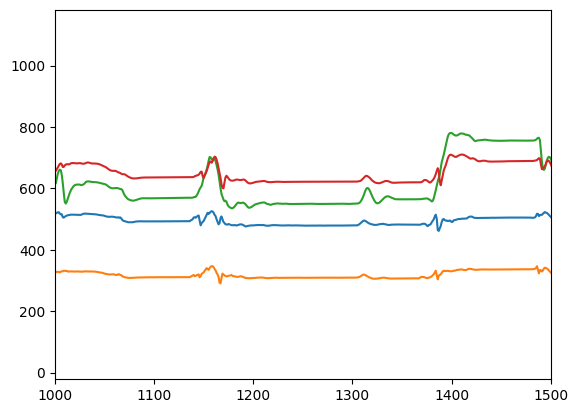

In [8]:
plt.plot(p2ds[0, :, 0])
plt.plot(p2ds[0, :, 1])
plt.plot(p2ds[1, :, 0])
plt.plot(p2ds[1, :, 1])
plt.xlim([1000, 1500])
plt.show()

In [9]:
def set_cam_params():
    FOCAL_LENGTH_MM = 16
    SENSOR_SIZE = 12.7
    IMG_HEIGHT = 512
    IMG_WIDTH = 640

    # rightCamera (treat this as origin)
    params_r = np.zeros(8)
    params_r[0:3] = np.array([0, 0, 0])  # rotation
    params_r[3:6] = np.array([0, 0, 0])  # translation
    params_r[6] = FOCAL_LENGTH_MM * IMG_WIDTH / SENSOR_SIZE  # in pixels
    # params_r[7:] are distortion params, init to zero
    size_r = (IMG_WIDTH, IMG_HEIGHT)
    cam_r = Camera(size=size_r)
    cam_r.set_params(params_r)
    # update principal point
    cam_r_mat = cam_r.get_camera_matrix()
    cam_r_mat[0, 2] = IMG_WIDTH
    cam_r_mat[1, 2] = IMG_HEIGHT
    cam_r.set_camera_matrix(cam_r_mat)

    # leftCamera
    params_l = np.zeros(8)
    params_l[0:3] = np.array([0, 2.0127, 0])  # rotation; around y axis only, about 120 deg (2.0127 rad) from Guido's CAD
    params_l[3:6] = np.array([-1.5664, 0, 2.4738])  # translation; cameras are 292.8 mm apart
    params_l[6] = FOCAL_LENGTH_MM * 2 * IMG_WIDTH / SENSOR_SIZE
    # params_l[7:] are distortion params, init to zero
    size_l = (2 * IMG_WIDTH, 2 * IMG_HEIGHT)
    cam_l = Camera(size=size_l)
    cam_l.set_params(params_l)
    # update principal point
    cam_l_mat = cam_l.get_camera_matrix()
    cam_l_mat[0, 2] = 2 * IMG_WIDTH
    cam_l_mat[1, 2] = 2 * IMG_HEIGHT
    cam_l.set_camera_matrix(cam_l_mat)

    cam_group = CameraGroup(cameras=[cam_r, cam_l])
    
    return cam_group

In [ ]:
## Test if triangulation is stochastic
cam_group = set_cam_params()

for i in range(5):
  pre = cam_group.get_dicts()
  p3ds = cam_group.triangulate(p2ds, progress=True)

  print(pre[0]['matrix'])
  plt.imshow(pre[0]['matrix'])
  plt.show()



[[806.2992125984252, 0.0, 640.0], [0.0, 806.2992125984252, 512.0], [0.0, 0.0, 1.0]]


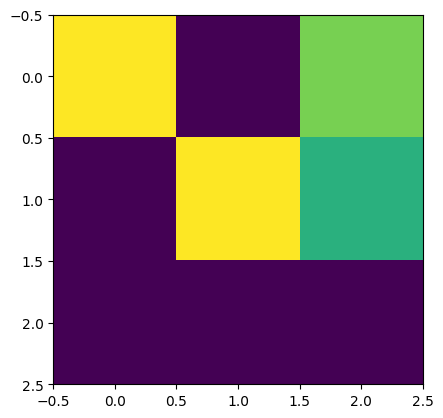

[[-0.023075522686427836, 0.0, 640.0], [0.0, -0.023075522686427836, 512.0], [0.0, 0.0, 1.0]]


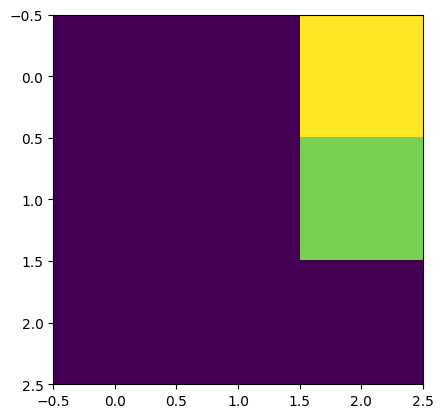

[[806.2992125984252, 0.0, 640.0], [0.0, 806.2992125984252, 512.0], [0.0, 0.0, 1.0]]


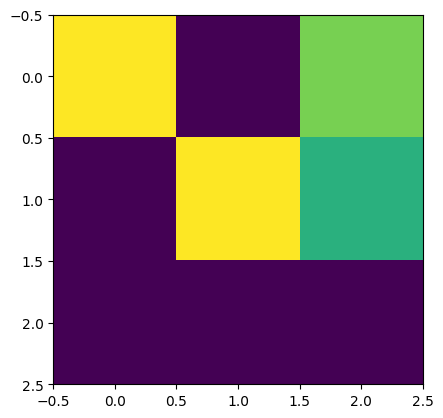

[[4657.2985005156925, 0.0, 640.0], [0.0, 4657.2985005156925, 512.0], [0.0, 0.0, 1.0]]


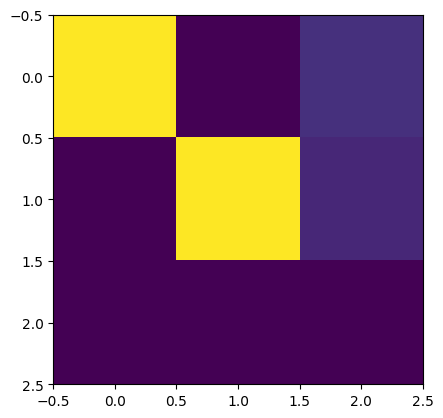

[[806.2992125984252, 0.0, 640.0], [0.0, 806.2992125984252, 512.0], [0.0, 0.0, 1.0]]


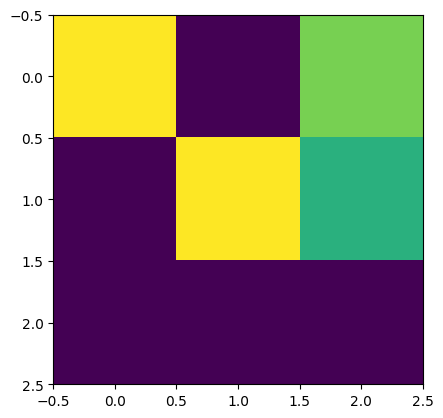

[[-4.439579083907081, 0.0, 640.0], [0.0, -4.439579083907081, 512.0], [0.0, 0.0, 1.0]]


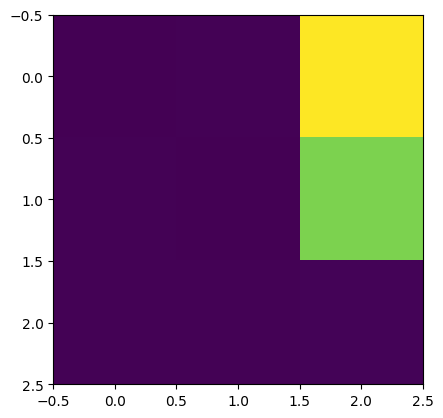

[[806.2992125984252, 0.0, 640.0], [0.0, 806.2992125984252, 512.0], [0.0, 0.0, 1.0]]


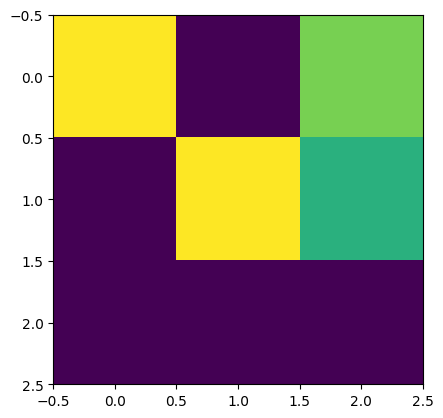

[[1975.5802994288026, 0.0, 640.0], [0.0, 1975.5802994288026, 512.0], [0.0, 0.0, 1.0]]


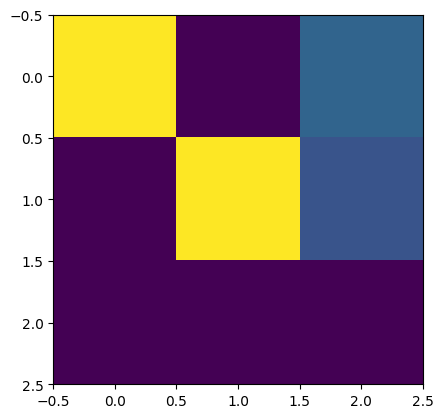

[[806.2992125984252, 0.0, 640.0], [0.0, 806.2992125984252, 512.0], [0.0, 0.0, 1.0]]


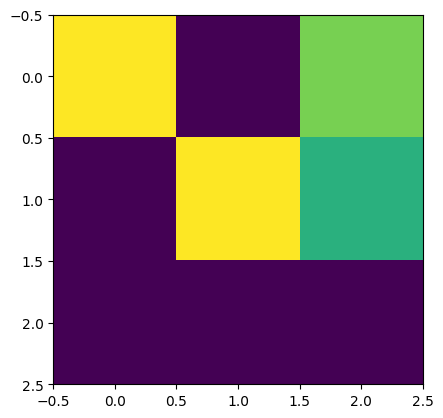

[[4.984475627193683, 0.0, 640.0], [0.0, 4.984475627193683, 512.0], [0.0, 0.0, 1.0]]


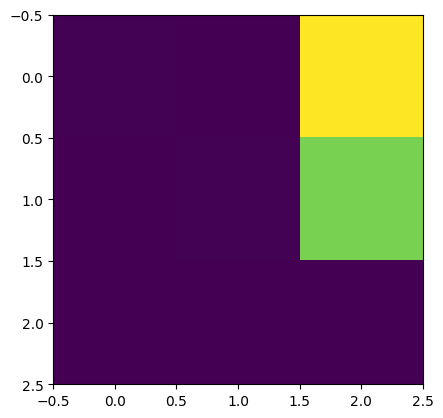

In [116]:
## Test if triangulation is stochartic
for i in range(5):
  cam_group = set_cam_params()
  pre = cam_group.get_dicts()

  cam_group.bundle_adjust_iter(p2ds, n_iters=20)  # Takes about 1 minuteCamera.get_params(cam_r)

  post = cam_group.get_dicts()
  print(pre[0]['matrix'])
  plt.imshow(pre[0]['matrix'])
  plt.show()
  print(post[0]['matrix'])
  plt.imshow(post[0]['matrix'])
  plt.show()
  # print(cam_group.get_params())

[[806.2992125984252, 0.0, 640.0], [0.0, 806.2992125984252, 512.0], [0.0, 0.0, 1.0]]


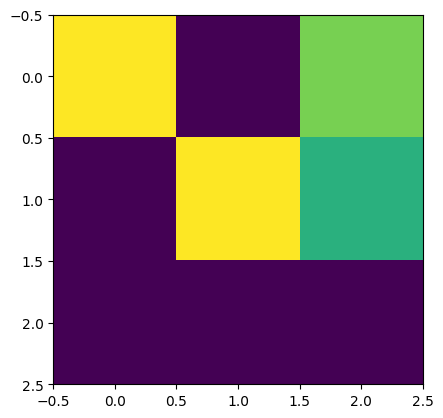

[[61.092167201132646, 0.0, 640.0], [0.0, 61.092167201132646, 512.0], [0.0, 0.0, 1.0]]


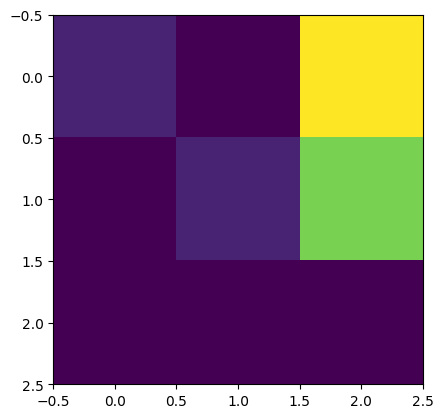

[[806.2992125984252, 0.0, 640.0], [0.0, 806.2992125984252, 512.0], [0.0, 0.0, 1.0]]


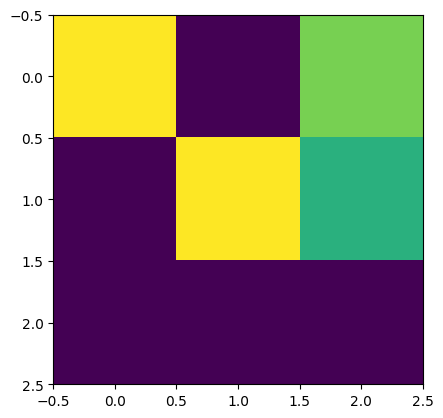

[[982.1112433855087, 0.0, 640.0], [0.0, 982.1112433855087, 512.0], [0.0, 0.0, 1.0]]


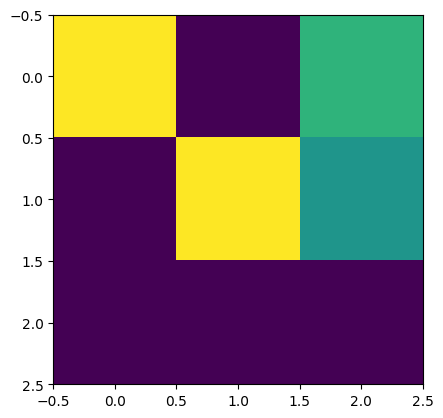

[[806.2992125984252, 0.0, 640.0], [0.0, 806.2992125984252, 512.0], [0.0, 0.0, 1.0]]


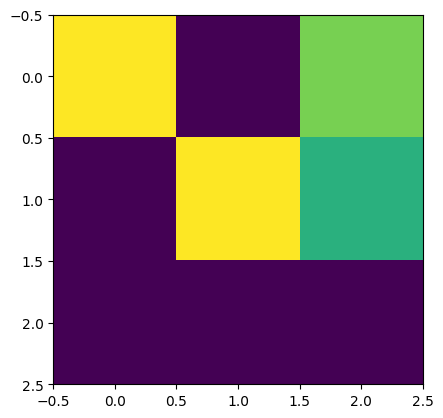

[[508.33441483819195, 0.0, 640.0], [0.0, 508.33441483819195, 512.0], [0.0, 0.0, 1.0]]


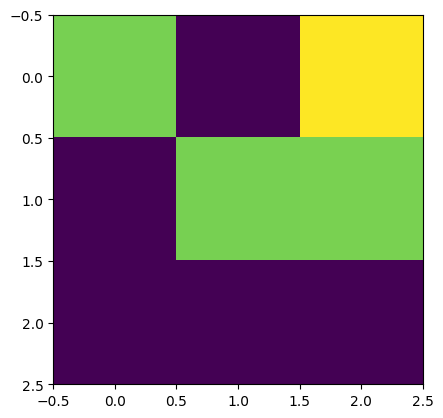

[[806.2992125984252, 0.0, 640.0], [0.0, 806.2992125984252, 512.0], [0.0, 0.0, 1.0]]


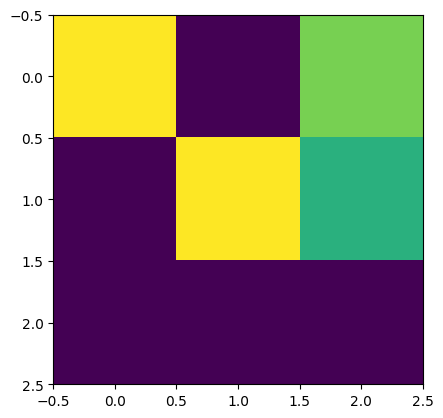

[[101.46198123616453, 0.0, 640.0], [0.0, 101.46198123616453, 512.0], [0.0, 0.0, 1.0]]


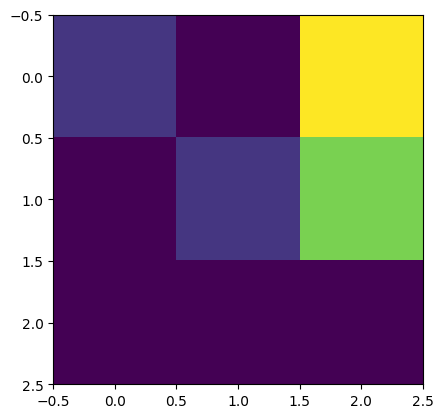

[[806.2992125984252, 0.0, 640.0], [0.0, 806.2992125984252, 512.0], [0.0, 0.0, 1.0]]


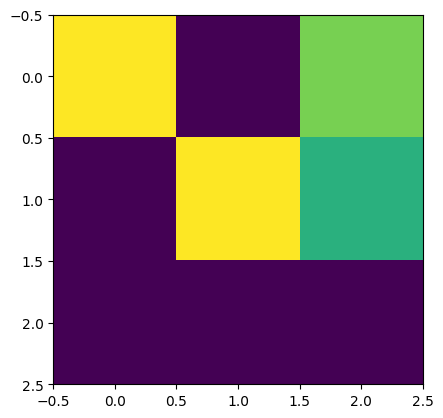

[[42.83761182717585, 0.0, 640.0], [0.0, 42.83761182717585, 512.0], [0.0, 0.0, 1.0]]


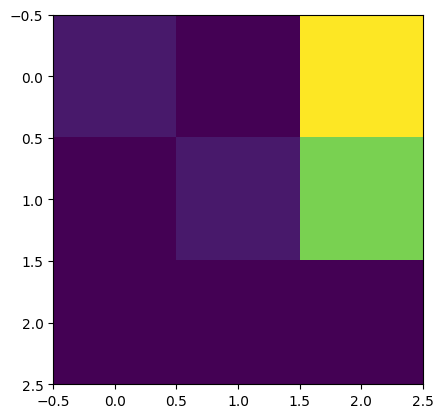

In [114]:
## Test if triangulation is stochartic
for i in range(5):
  cam_group = set_cam_params()
  pre = cam_group.get_dicts()

  cam_group.bundle_adjust_iter(p2ds, n_iters=6)  # Takes about 1 minuteCamera.get_params(cam_r)

  post = cam_group.get_dicts()
  print(pre[0]['matrix'])
  plt.imshow(pre[0]['matrix'])
  plt.show()
  print(post[0]['matrix'])
  plt.imshow(post[0]['matrix'])
  plt.show()
  # print(cam_group.get_params())


In [119]:
## Test if triangulation is stochartic
for i in range(5):
  cam_group = set_cam_params()
  pre = cam_group.get_dicts()

  cam_group.bundle_adjust_iter(p2ds, n_iters=20)  # Takes about 1 minuteCamera.get_params(cam_r)

  post = cam_group.get_dicts()
#   print(pre[0]['matrix'])
  print(pre[0]['distortions'])
#   print(pre[0]['rotation'])
#   print(pre[0]['translation'])

#   print(post[0]['matrix'])
  print(post[0]['distortions'])
#   print(post[0]['rotation'])
#   print(pre[0]['translation'])

  # print(cam_group.get_params())

[0.0, 0.0, 0.0, 0.0, 0.0]
[10.788465991031297, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[3.6873022235319457, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.007941086679898724, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.5055831180171354, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.00011922033687689071, 0.0, 0.0, 0.0, 0.0]


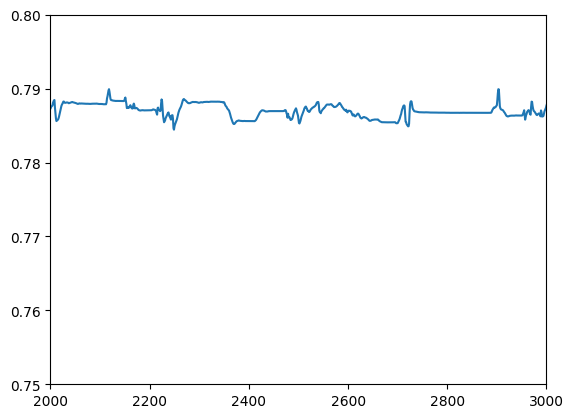

In [54]:
  plt.plot(p3ds[:, 2])
  # plt.plot(reprojerr_flat/200)
  plt.xlim([init, init+1000])
  plt.ylim([.75, .8])
plt.show()


100%|███████████████████████| 291014/291014 [00:48<00:00, 5983.41it/s]


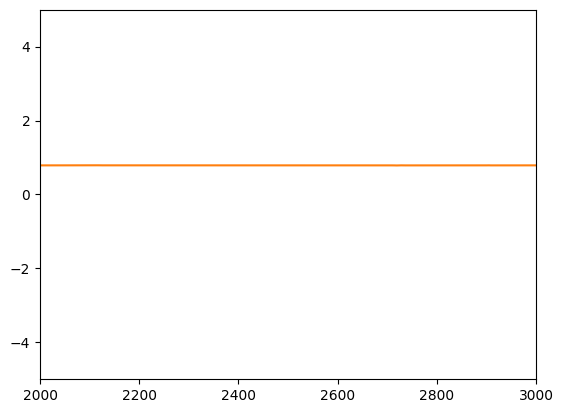

In [50]:
init = 2000
## Test if triangulation is stochartic
for i in range(2):
  cam_group = set_cam_params()
  cam_group.bundle_adjust_iter(p2ds, n_iters=100)  # Takes about 1 minute
  p3ds = cam_group.triangulate(p2ds, progress=True)
  # reprojerr_flat = cam_group.reprojection_error(p3ds, p2ds, mean=True)

  # p3ds = p3ds_flat.reshape(n_points, n_joints, 3)
  # reprojerr = reprojerr_flat.reshape(n_points, n_joints)
  # Camera.get_params(cam_l)

  
#   plt.plot(p3ds[:, 0]+1.3, alpha=alphas[i])
#   plt.plot(p3ds[:, 1]+1, alpha=alphas[i])
  plt.plot(p3ds[:, 2])
  # plt.plot(reprojerr_flat/200)
  plt.xlim([init, init+1000])
  plt.ylim([-10, 10])
plt.show()


(-5.0, 10.0)

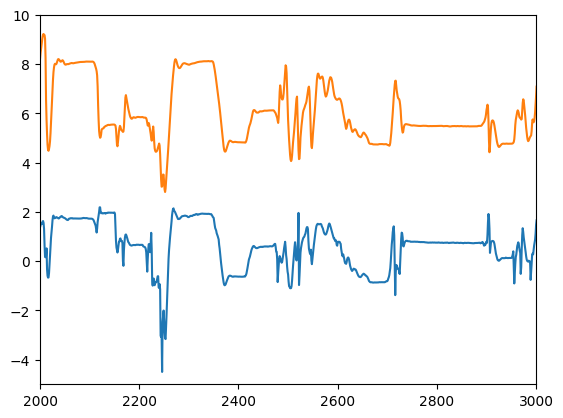

In [48]:
  plt.plot(p3ds[:, 2])
  plt.plot(p2ds[1, :, 0]/40-5)
  plt.xlim([init, init+1000])
  plt.ylim([-5, 10])


In [177]:
p3ds = cam_group.triangulate(p2ds, progress=True)

100%|███████████████████████| 291014/291014 [02:57<00:00, 1642.35it/s]


In [ ]:
alphas = [1, .4]
for i, n_iters in enumerate([1, 100]):
  
  p3ds = cam_group.triangulate(p2ds, progress=True)
  reprojerr_flat = cam_group.reprojection_error(p3ds, p2ds, mean=True)

  # p3ds = p3ds_flat.reshape(n_points, n_joints, 3)
  # reprojerr = reprojerr_flat.reshape(n_points, n_joints)
  # Camera.get_params(cam_l)

  init = 2000

#   plt.plot(p3ds[:, 0]+1.3, alpha=alphas[i])
#   plt.plot(p3ds[:, 1]+1, alpha=alphas[i])
  plt.plot(p3ds[:, 2], alpha=alphas[i])
  # plt.plot(reprojerr_flat/200)
  plt.xlim([init, init+1000])
plt.show()

# plt.plot(p2ds[0, :, 0])
# plt.plot(p2ds[0, :, 1])
# plt.plot(p2ds[1, :, 0])
# plt.plot(p2ds[1, :, 1])
# plt.xlim([init, init+1000])
# plt.show()

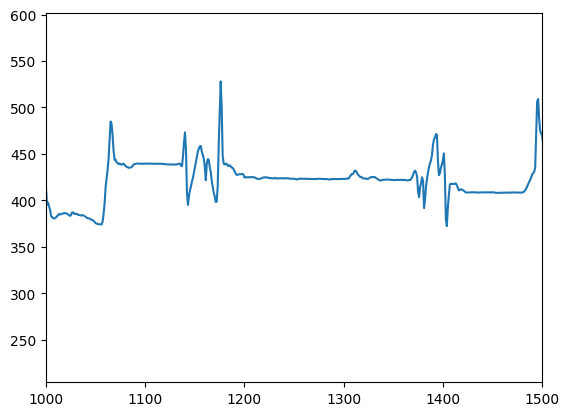

In [176]:
init = 1000
plt.plot(p2ds[0, :, 0])
# plt.plot(p3ds[:, 1])
# plt.plot(p3ds[:, 2])
# plt.plot(reprojerr_flat/200)
plt.xlim([init, init+500])
# plt.ylim([-.5, .5])
plt.show()

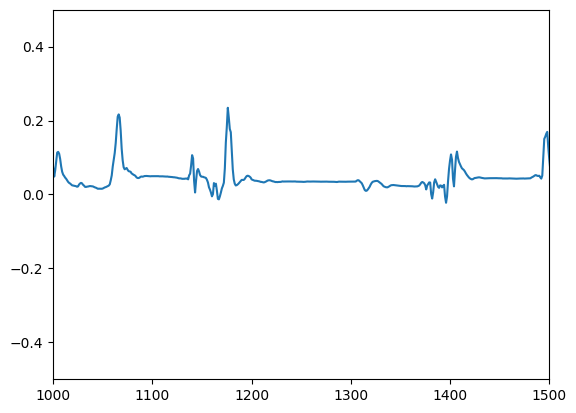

In [181]:
init = 1000
plt.plot(p3ds[:, 0])
# plt.plot(p3ds[:, 1])
# plt.plot(p3ds[:, 2])
# plt.plot(reprojerr_flat/200)
plt.xlim([init, init+500])
plt.ylim([-.5, .5])
plt.show()

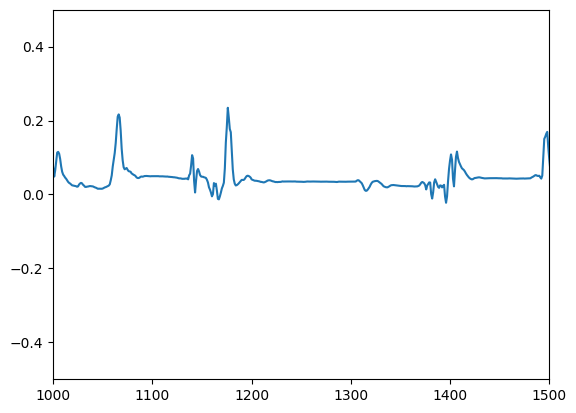

In [171]:
init = 1000
plt.plot(p3ds[:, 0])
# plt.plot(p3ds[:, 1])
# plt.plot(p3ds[:, 2])
# plt.plot(reprojerr_flat/200)
plt.xlim([init, init+500])
plt.ylim([-.5, .5])
plt.show()